# Refining the spin direction and ordered moment

This notebook provides examples of two methods for refining the spin direction: 
   1. Updating the basis vector(s) and calling the makeSpins() function, which is a very general method and will work for magnetic structures of arbitrary complexity;
   2. Storing the locations of the "up" spins and "down" spins and updating them without calling makeSpins(), which is faster and well suited for simple collinear magnetic structures.
   
We also provide an example of refining the ordered moment directly and calculating the uncertainties of the fit parameters.

In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *
from diffpy.structure import loadStructure
from scipy.optimize import least_squares

### Set all plots to be inline
%matplotlib notebook

In [3]:
### Get the data
r,d = getDiffData('MnOfit_PDFgui_NOMAD.fgr')


### Make the magnetic structure
struc = loadStructure('MnO_struc_NOMAD.stru')

svec = np.array([0,0,1]) # start with an incorrect spin orientation to ensure we converge to the right direction
msp = MagSpecies(struc,strucIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=r.max(),basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label='Mn')

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()


### Make the calculator
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()
mc.qdamp = 0.024

### Define a residual function that allows moment directions to vary

<IPython.core.display.Javascript object>


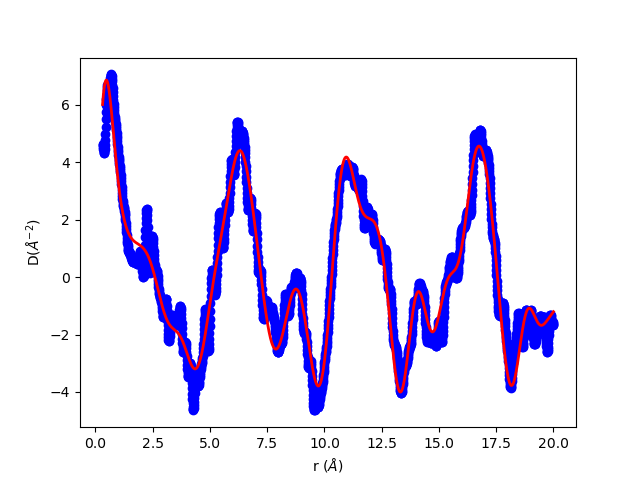

In [4]:
def residual(p,ydata):
    oscale,pscale,th,phi = p
    newsvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    msp.basisvecs = newsvec
    mstr.makeSpins()
    mc.ordScale = oscale
    mc.paraScale = pscale
    return ydata - mc.calc(both=True)[2]

p0 = [0.1,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,-np.pi],[10,10,np.pi,np.pi]], args=(d,))
fit = d - residual(optimized.x, d)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,d,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()    

### Visualize the refined magnetic structure

<IPython.core.display.Javascript object>


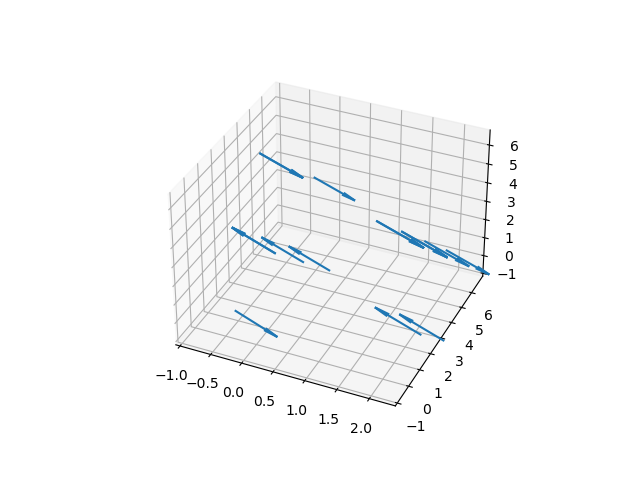

[ 0.7951161  -0.54628126 -0.26337648] -0.014541645558752148


In [5]:
### Visualize the magnetic structure
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

print(mstr.spins[0], (mstr.spins[0]).sum())

The refined spin direction is nearly perfectly perpendicular to the (111) direction, in agreement with the known magnetic structure of MnO.

### Faster method: Use masking to avoid having to regenerate spins each iteration

In [9]:
### Get the data
r,d = getDiffData('MnOfit_PDFgui_NOMAD.fgr')


### Make the magnetic structure
struc = loadStructure('MnO_struc_NOMAD.stru')

svec = np.array([0,0,1]) # start with an incorrect spin orientation to ensure we converge to the right direction
msp = MagSpecies(struc,strucIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=r.max(),basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label='Mn')

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

### Make the calculator
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()
mc.qdamp = 0.024

In [10]:
### Make the masks
upMask = (np.apply_along_axis(np.linalg.norm,1,mstr.spins-svec)<0.1)
downMask = ~upMask
print(mstr.spins[upMask][:4])
print(mstr.spins[downMask][:4])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]]


<IPython.core.display.Javascript object>


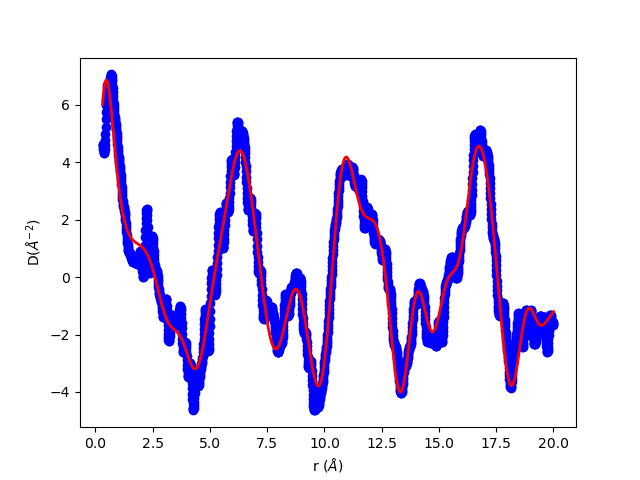

[-0.75595994  0.13036375  0.64150593] 0.0159097360988969


In [11]:
def residual(p,ydata):
    oscale,pscale,th,phi = p
    newsvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.spins[upMask] = newsvec
    mstr.spins[downMask] = -newsvec
    mc.ordScale = oscale
    mc.paraScale = pscale
    r, fr, dr = mc.calc(both=True)
    return ydata - dr

p0 = [0.1,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,-np.pi],[10,10,np.pi,np.pi]],args=(d,))
fit = d - residual(optimized.x, d)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,d,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()    

print(mstr.spins[0],(mstr.spins[0]).sum())

In [12]:
plt.close('all')

## Refine the ordered moment directly from the fit

The introductory tutorial demonstrated how to calculate the ordered moment given the ordScale value of the MPDFcalculator and the scale factor for the atomic PDF. Here, we show how to refine the ordered moment directly, as well as how to generate uncertainties for the values of the refined parameters.

In [13]:
### Get the data
r,d = getDiffData('MnOfit_PDFgui_NOMAD.fgr')


### Make the magnetic structure
struc = loadStructure('MnO_struc_NOMAD.stru')

svec = np.array([0,0,1]) # start with an incorrect spin orientation to ensure we converge to the right direction
msp = MagSpecies(struc,strucIdxs=[0,1,2,3],ffparamkey='Mn2',rmaxAtoms=r.max(),basisvecs=svec,
                kvecs=np.array([0.5,0.5,0.5]),label='Mn')

mstr=MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

### Make the calculator
mc = MPDFcalculator(mstr)
mc.rmin = r.min()
mc.rmax = r.max()
mc.qdamp = 0.024

In [14]:
### Make the masks
upMask = (np.apply_along_axis(np.linalg.norm,1,mstr.spins-svec)<0.1)
downMask = ~upMask
print(mstr.spins[upMask][:4])
print(mstr.spins[downMask][:4])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]]


So far, everything has been the same. Now we modify the residual function in the cell below to convert the ordered moment (a free parameter) into the corresponding ordScale value for the MPDFcalculator. We use the calculate_ordered_scale() function, which takes as input the MagStructure object, the current value of the ordered moment in Bohr magnetons, and the scale factor for the atomic PDF fit (0.05277 in this case).

<IPython.core.display.Javascript object>


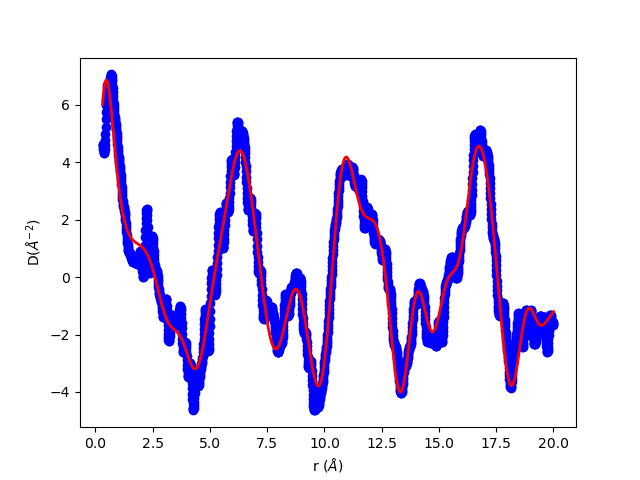

In [15]:
def residual(p,ydata):
    moment,pscale,th,phi = p
    newsvec = np.array([np.sin(th)*np.cos(phi),np.sin(th)*np.sin(phi),np.cos(th)])
    mstr.spins[upMask]=newsvec
    mstr.spins[downMask]=-newsvec
    mc.ordScale = calculate_ordered_scale(mstr, moment, 0.05277) # convert the moment into a scale factor
    mc.paraScale = pscale
    r, fr, dr = mc.calc(both=True)
    return ydata - dr

p0 = [5,0.1,np.arccos(np.random.uniform(-1,1)),np.random.uniform(-np.pi,np.pi)]
optimized = least_squares(residual,p0,bounds=[[0,0,0,-np.pi],[10,10,np.pi,np.pi]],args=(d,))
fit = d - residual(optimized.x, d)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(r,d,'bo',linestyle='none')
ax.plot(r,fit,'r-',lw=2)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('D($\AA^{-2}$)')

plt.show()

Now let's print the refined parameter values and their uncertainties. We calculate the uncertainties using the function getStdUnc(), which takes as input the optimization object returned by least_squares, the data against which the fit was performed, and (optionally) the number of constraints on the fitting parameters (zero in this case).

In [16]:
vals = optimized.x
uncertainties, chisquared = getStdUnc(optimized, d)
names = ['moment', 'paramagnetic scale', 'theta', 'phi']

for idx, name in enumerate(names):
    print(name, vals[idx], uncertainties[idx])

moment 4.72872690303767 0.0178196883486722
paramagnetic scale 0.23343537827619307 0.012127270441911326
theta 2.354767723654026 6755.914775399609
phi 1.5845316662216258 2268.9991957661287


Note that the uncertainties for theta and phi are incredibly large. This is because there is no unique set of theta and phi values that give the best fit. Based on the symmetry of the structure, any spin direction perpendicular to the (111) direction gives an identical mPDF pattern. Because of this degeneracy, meaningful uncertainties for theta and phi cannot be produced when both are used as free parameters.

In [11]:
plt.close('all')